# <center> Линейная алгебра в контексте линейных методов. Практика 1

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на два отдельных домашних задания:
* В первом задании мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во втором задании мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

%matplotlib inline

Прочитаем исходные данные:

In [2]:
df = pd.read_csv('../data/dataset.csv')
df.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


In [3]:
df.shape

(200, 8)

## Линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 1.0–1.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 1.0

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


Здорово, что `null` значений у нас нет

Рассмотрим наши гистрограммы - как данные распределяются внутри?

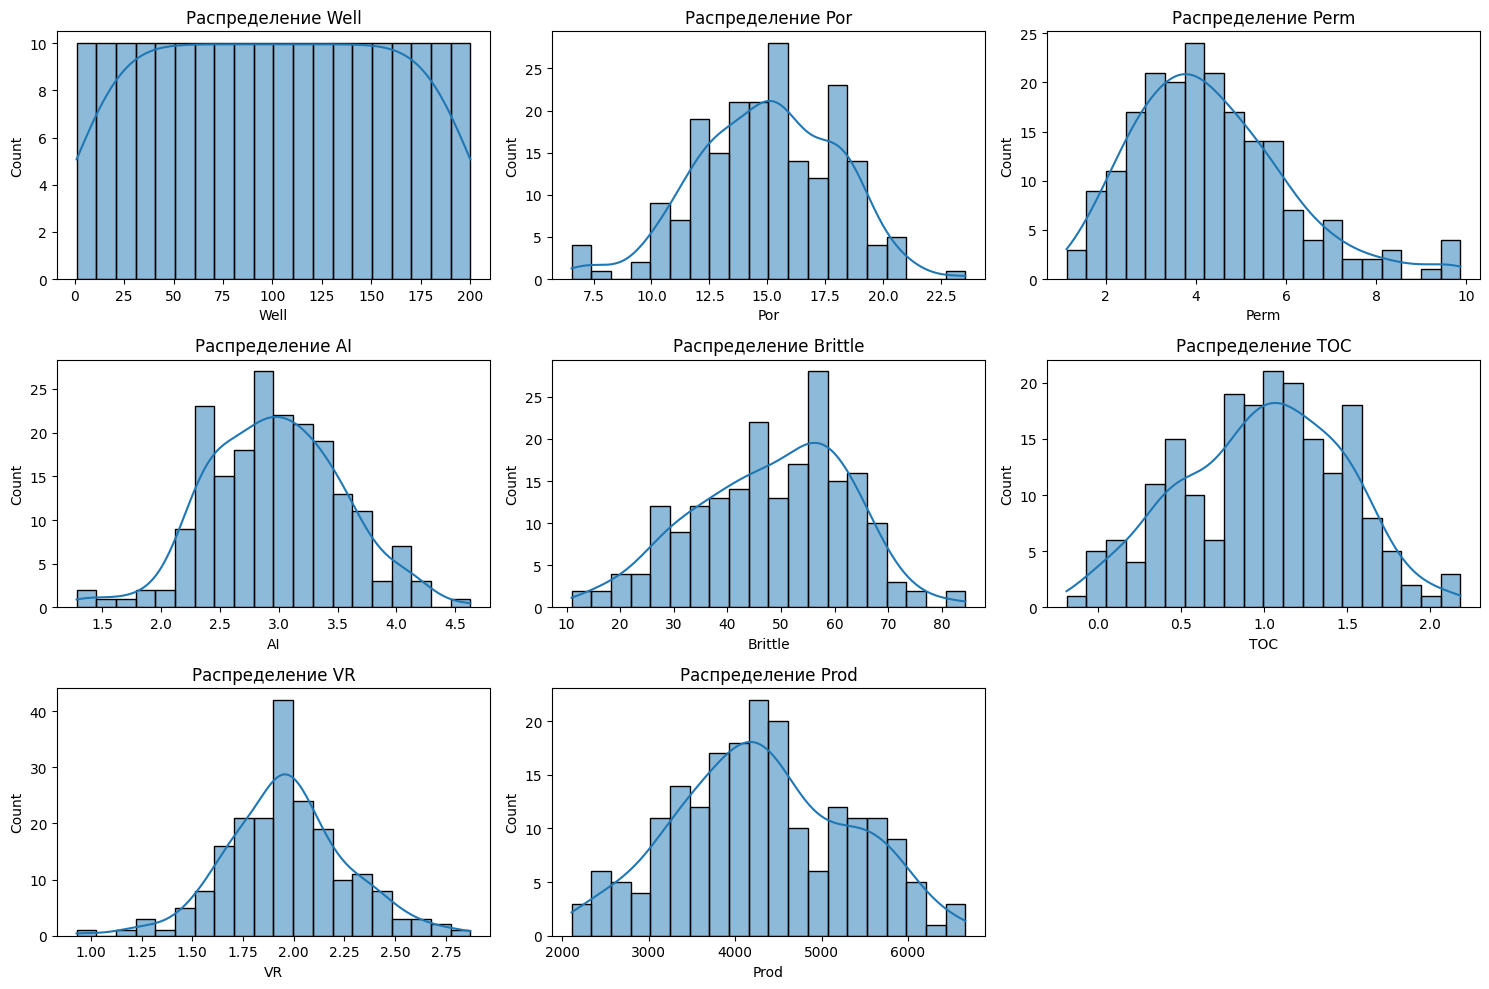

In [11]:
plt.figure(figsize=(15, 10))

for i, feature in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, bins=20)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

Неудивительно что в Well такой равномерный график, там уникальные идентификаторы:

In [12]:
assert len(df.Well.unique()) == len(df)

Во всех остальных графиках плюс минус что-то похожее на нормальное распределение

Объём данных небольшой, так что мы можем проверить выбросы:

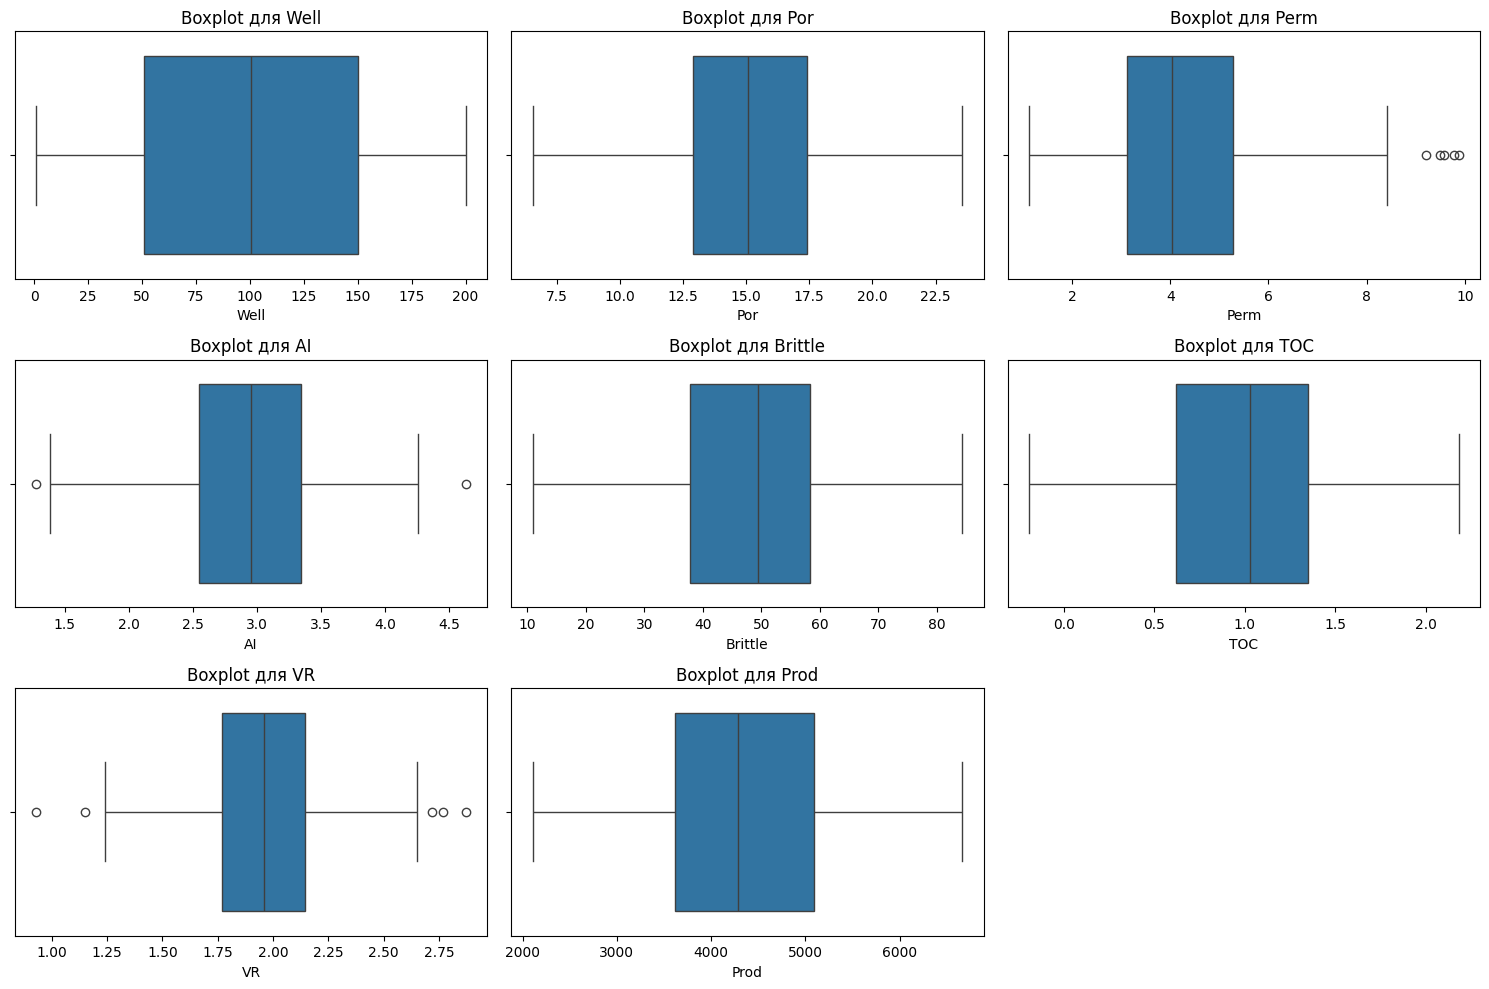

In [17]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(df.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x=feature)
    plt.title(f'Boxplot для {feature}')
plt.tight_layout()
plt.show()

Гигантских выбросов я не вижу, хотя у VR ситуация явно более неоднозначная чем у TOC и Prod

### Задание 1.1 (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

#### Решение

In [18]:
corr_matrix = df.corr()

Наша корреляционная матрица факторов - `corr_matrix`

Воспользуемся `seaborn` для визуализации корреляции признаков:

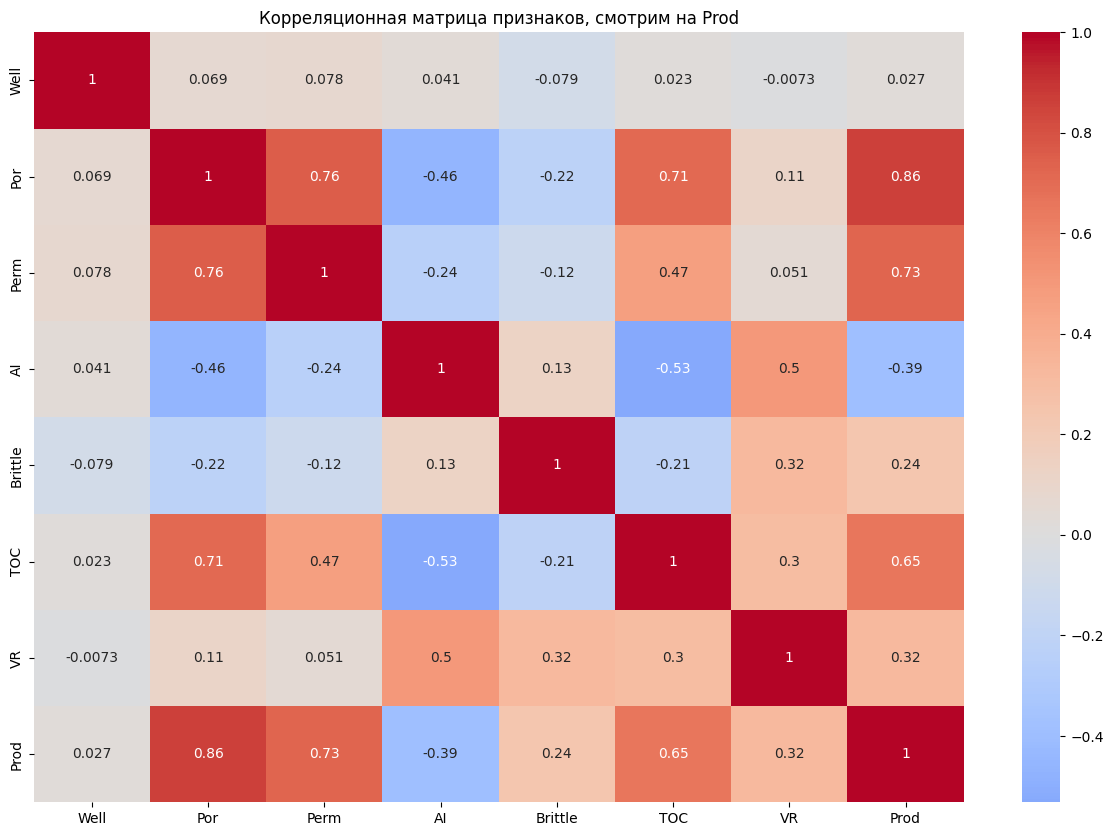

In [22]:
plt.figure(figsize=(15, 10))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица признаков, смотрим на Prod')
plt.show()

Мы видим, что `Prod` явно коррелирует с `Por` (0.86), `Perm` (0, 73), возможно коррелирует с `TOC` (0,65) и слабо обратно с `AI` (-0.39).

Напомним:
- `Por` — пористость скважины 
- `Perm` — проницаемость скважины
- `AI` — акустический импеданс
- `TOC` — общий органический углерод 

Найдём определитель и ранг с помощью `numpy`:

In [23]:
det = np.linalg.det(corr_matrix)
rank = np.linalg.matrix_rank(corr_matrix)

print(f'Определитель матрицы: {det}\nРанг матрицы: {rank}')

Определитель матрицы: 0.0007299388072652095
Ранг матрицы: 8


Наш определитель очень мал: $0.0007$. Значит, матрица плохо обусловлена, то есть признаки **мультиколлинеарны**.

Выходит, некоторые признаки имеют сильную зависимость друг от друга.

**Метод наименьших квадратов** будет неустойчив: сильно зависимые признаки перекрывают друг друга. Вообще, нам бы в таком случае больше помогла регуляризация 🤔

### Задание 1.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

#### Решение

Выделим все признаки в матрицу `X`, а целевой `Prod` - в вектор `y`:

In [71]:
# добавим для лучшего вывода numpy-кода
np.set_printoptions(suppress=True, precision=3)

In [66]:
X = df.drop(columns=['Prod'])

y = df['Prod']

In [69]:
X

,Well,Por,Perm,AI,Brittle,TOC,VR
0,1,12.08,2.92,2.80,81.40,1.16,2.31
1,2,12.38,3.53,3.22,46.17,0.89,1.88
2,3,14.02,2.59,4.01,72.80,0.89,2.72
3,4,17.67,6.75,2.63,39.81,1.08,1.88
4,5,17.52,4.57,3.18,10.94,1.51,1.90
...,...,...,...,...,...,...,...
195,196,11.95,3.13,2.97,67.18,0.80,2.06
196,197,17.99,9.87,3.38,44.32,0.98,2.08
197,198,12.12,2.27,3.52,57.07,-0.04,1.73
198,199,15.55,4.48,2.48,58.25,1.89,2.35


In [72]:
X.values

array([[  1.  ,  12.08,   2.92, ...,  81.4 ,   1.16,   2.31],
       [  2.  ,  12.38,   3.53, ...,  46.17,   0.89,   1.88],
       [  3.  ,  14.02,   2.59, ...,  72.8 ,   0.89,   2.72],
       ...,
       [198.  ,  12.12,   2.27, ...,  57.07,  -0.04,   1.73],
       [199.  ,  15.55,   4.48, ...,  58.25,   1.89,   2.35],
       [200.  ,  20.89,   7.54, ...,  46.17,   1.71,   2.27]])

Добавим к `X` столбец единиц, для учёта свободных членов:

In [82]:
one_col = np.ones((len(X), 1))

X = np.hstack([one_col, X.values])

Формула метода наименьших квадратов:

$$
V = (X^T X)^{-1} X^T y,
$$
где:
- $X$ - наша матрица `X` с добавленным столбцом единиц
- $y$ - целевой вектор `Prod`
- $V$ - вектор коэффициентов регрессии

In [84]:
Xt = X.T

XtX = Xt @ X
XtXinv = np.linalg.inv(XtX)

Xty = Xt @ y

V = XtXinv @ Xty

In [93]:
np.round(V)

array([-1232.,     0.,   230.,   116.,  -365.,    25.,   -78.,   785.])

Коэффициенты показывают влияние каждого признака на `Prod`, если остальные признаки фиксированы. 

Чем ближе модуль признака к нулю, тем меньше он оказывает влияния на переменную, или несёт только шум. 

В нашем случае:

- `well` - признак не оказывает никакого влияния на `prod`, в идентификаторе нет отношения к добыче газа. Мы можем дропать признак 😉 
- `por` - признак имеет умеренное влияние на `prod`: при увеличении пористости на 1% добыча газа увеличивается на 230 млн. куб. футов.
- `ai` - признак имеет сильную обратную зависимость с `prod`, влияние по модулю - второе из всех признаков. При увеличении акустического импеданса на 1 добыча газа снижается на 365 млн футов. Нам необходимо учитывать данный признак
- `vr` - признак с критической зависимостью с `prod`, наибольший коэффициент корреляции. При увеличении коэффициента отражения витринита на 1 мы ожидаем увеличение добычи газа на 785 кубических футов. Соответственно, мы точно будем рассматривать данный признак

### Задание 1.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

#### Решение а)

Сначала мы создадим прогноз по формуле:

$$
\text{Прогноз} = \text{свободный член} + \sum ( \text{коэффициент}_i \times \text{значение признака}_i)
$$

Затем найдём абсолютную ошибку: разницу между предсказанным значением и фактическим значением

In [98]:
params = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }

In [96]:
first_c = V[0]
coefs = V[1:]

In [101]:
param_values = np.array([params['Well'], params['Por'], params['Perm'],
                            params['AI'], params['Brittle'], params['TOC'], params['VR']])

In [103]:
prediction = first_c + np.dot(coefs, param_values)

In [107]:
print(f'Прогноз выработки газа: {prediction}')

Прогноз выработки газа: 4723.064053707353


In [105]:
actual_value = 4748.315024

In [106]:
abs_error = prediction - actual_value

print(f'Абсолютная ошибка: {abs_error}')

Абсолютная ошибка: -25.250970292647253


#### Решение б)

Я думаю мы будем использовать две метрики: 

1. Среднеквадратичная ошибка. Она штрафует отклонения за счет того, что возводит их в квадрат. По ней мы увидим, есть ли большие выбросы
2. Средняя абсолютная ошибка. Она менее чувствительна к выбросам, и лучше показывает картину в целом

Вместе на обеих метриках мы сможем оценить работу модели и верхнеуровнево, и в деталях

In [110]:
# импортнём либы из сайкитлёрна 

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [112]:
X[:, 1:]

array([[  1.  ,  12.08,   2.92, ...,  81.4 ,   1.16,   2.31],
       [  2.  ,  12.38,   3.53, ...,  46.17,   0.89,   1.88],
       [  3.  ,  14.02,   2.59, ...,  72.8 ,   0.89,   2.72],
       ...,
       [198.  ,  12.12,   2.27, ...,  57.07,  -0.04,   1.73],
       [199.  ,  15.55,   4.48, ...,  58.25,   1.89,   2.35],
       [200.  ,  20.89,   7.54, ...,  46.17,   1.71,   2.27]])

In [113]:
new_predictions = first_c + X[:, 1:] @ coefs

In [115]:
mse = mean_squared_error(y, new_predictions)
mae = mean_absolute_error(y, new_predictions)

In [116]:
print(f'Среднеквадратичная ошибка: {mse}')
print(f'Средняя абсолютная ошибка: {mae}')

Среднеквадратичная ошибка: 39315.04014026637
Средняя абсолютная ошибка: 153.6229708655639


Средняя абсолютная ошибка у нас в целом не критичная. Но вот среднеквадратичная ошибка нереально высокая - значит в отдельных выбросах модель очень сильно ошибается.

Как я и говорил раньше, придётся применять регуляризацию

### Задание 1.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

#### Решение

Найдём коэффициенты корреляции признаков с нашим искомым `Prod`:

In [132]:
corr_coefs = corr_matrix['Prod'][:-1]
corr_coefs

Well       0.026817
Por        0.861910
Perm       0.727426
AI        -0.390835
Brittle    0.237155
TOC        0.654445
VR         0.323182
Name: Prod, dtype: float64

In [133]:
corr_coefs_sign = np.sign(corr_coefs)
corr_coefs_sign

Well       1.0
Por        1.0
Perm       1.0
AI        -1.0
Brittle    1.0
TOC        1.0
VR         1.0
Name: Prod, dtype: float64

Посмотрим на коэффициенты модели:

In [135]:
coefs  # наши коэффициенты, мы нашли их выше

array([   0.051,  230.179,  116.239, -365.202,   24.994,  -78.401,
        785.26 ])

In [136]:
model_coefs_sign = np.sign(coefs)

In [138]:
df.columns[:-1]

Index(['Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR'], dtype='object')

In [139]:
probs = []
for col, corr_sign, model_sign in zip(df.columns[:-1], corr_coefs_sign, model_coefs_sign):
    if corr_sign != model_sign:
        probs.append(col)

In [140]:
probs

['TOC']

Так мы обнаружили, что для `TOC` знак корреляции отличается от знака коэффициента модели. То есть модель говорит что зависимость обратная, а корреляция-то прямая 🤔 

Это могло бы быть связано с мультиколлинеарностью или выбросом в данных 

### Задание 1.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

#### Решение

Я чувствую, что переменные скоро начнут наслаиваться друг на друга. Поэтому сделаю ресет, тем самым очищу память, и запущу пару первых ячеек с прочтением датасета.

In [4]:
correlation_matrix = df.corr()

In [12]:
target_correlations = correlation_matrix['Prod'].abs()

In [9]:
high_corr_pairs = {} 

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        factor_1 = correlation_matrix.columns[i]
        factor_2 = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        
        if abs(corr_value) > 0.7 and factor_1 != 'Prod' and factor_2 != 'Prod':
            high_corr_pairs[(factor_1, factor_2)] = abs(corr_value)

In [13]:
factors_to_remove = set() 

for factor_1, factor_2 in high_corr_pairs:
    if target_correlations[factor_1] > target_correlations[factor_2]:
        factors_to_remove.add(factor_2)
    else:
        factors_to_remove.add(factor_1)

low_corr_factors = target_correlations[target_correlations < 0.05].index
factors_to_remove.update(low_corr_factors)

df_cleaned = df.drop(columns=factors_to_remove)

In [15]:
df_cleaned.head(1)

,Por,AI,Brittle,VR,Prod
0,12.08,2.8,81.4,2.31,4165.196191


In [16]:
print(f'Факторы, которые были удалены: {factors_to_remove}')
print(f'Оставшиеся факторы в данных: {df_cleaned.columns}')

Факторы, которые были удалены: {'Perm', 'Well', 'TOC'}
Оставшиеся факторы в данных: Index(['Por', 'AI', 'Brittle', 'VR', 'Prod'], dtype='object')


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
X_updated = df_cleaned.drop(columns=['Prod'])
y_updated = df_cleaned['Prod']

X_with_bias = np.hstack([np.ones((X_updated.shape[0], 1)), X_updated.values])

y_array = y_updated.values

In [19]:
X_transpose = X_with_bias.T                   
X_transpose_X = X_transpose @ X_with_bias     
X_transpose_X_inv = np.linalg.inv(X_transpose_X)  
X_transpose_y = X_transpose @ y_array         
beta = X_transpose_X_inv @ X_transpose_y      
beta

array([-1835.44646069,   293.03624565,  -200.03091206,    27.64098209,
         517.40272597])

In [21]:
predictions = X_with_bias @ beta

mse = mean_squared_error(y_array, predictions)
mae = mean_absolute_error(y_array, predictions)

print("Среднеквадратичная ошибка:", mse)
print("Средняя абсолютная ошибка:", mae)

Среднеквадратичная ошибка: 53660.854579235325
Средняя абсолютная ошибка: 171.43146059581167


... Стало хуже 😆 😭

Возможно дело в том, что я удалил слишком много данных. На деле оказывается, что данные-то были не лишние, и зря мы их удаляли 

**Вывод:** После удаления сильно коррелированных факторов я ожидал что коэффициенты станут более интерпретируемыми, так как влияние мультиколлинеарности уменьшилось. Но метрики `MSE` и `MAE`  увеличились (до 53660 и 171). Выходит, что я потерял в точности модели после удаления факторов. Видимо, модели теперь не хватает информации. 

Я хотел оптимизировать коэффициенты, а в итоге потерял в качестве модели 😔

### Задание 1.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [24]:
X_updated = df_cleaned.drop(columns=['Prod']).values
y_updated = df_cleaned['Prod'].values

model = LinearRegression()
model.fit(X_updated, y_updated)

coefficients = np.round(model.coef_)  # Округляем коэффициенты до целого
intercept = np.round(model.intercept_)  # Округляем свободный член до целого

print("Округленные коэффициенты модели:", coefficients)
print("Свободный член:", intercept)

Округленные коэффициенты модели: [ 293. -200.   28.  517.]
Свободный член: -1835.0


In [25]:
predictions = model.predict(X_updated)
mse_sklearn = mean_squared_error(y_updated, predictions)
mae_sklearn = mean_absolute_error(y_updated, predictions)

print("Среднеквадратичная ошибка для sklearn модели:", mse_sklearn)
print("Средняя абсолютная ошибка для sklearn модели:", mae_sklearn)

Среднеквадратичная ошибка для sklearn модели: 53660.854579235325
Средняя абсолютная ошибка для sklearn модели: 171.4314605958078


Sklearn модель дала такие же результаты, как у нас в Задании 5.5! Приятненько 🤗

Из минусов - лучше результаты не стали)) А значит с удалением, казалось бы, лишних столбцов мы получаем результаты хуже. Но возможно дело в том, что наша модель переобучилась на данных, и нам помогут методы оптимизации на малых данных. Проверим их в следующем домашнем задании